### Imports

In [9]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader

import src.simclr as simclr
from src.data_loading import get_data_loader

### Params

In [24]:
dim = 6
n_layers = 4
n_epochs = 1000
n_points = 100
b_size = 100
min_t, max_t = (0.0, pi / 2.0)

### Generate data

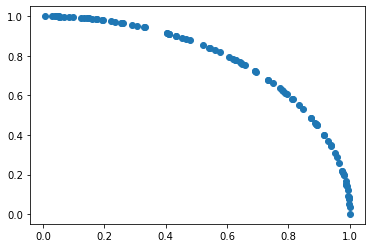

In [25]:
thetas = np.random.rand(n_points) * (max_t - min_t) + min_t
x = np.cos(thetas)
y = np.sin(thetas)
plt.scatter(x, y)

In [26]:
def to_dataset(x, y):
    d = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    d = torch.from_numpy(d).float()
    return data.TensorDataset(d)


def block(d, num):
    unit = nn.Sequential(nn.Linear(d, d), nn.GELU())
    from copy import deepcopy

    return nn.Sequential(
        *[deepcopy(unit) for _ in range(num)], nn.Linear(d, 2)
    )


def plot_vec(tensor):
    if tensor.size(0) % 5 != 0:
        print("pass plotting step, not // 5")
        return
    if tensor.size(1) != 2 or tensor.dim() > 2:
        print(tensor.dim())
        print("pass plotting step, not batch + 2d data")
        return
    plt.figure()
    n = tensor.size(0) // 5
    print(
        "Input data distribution, blue = original data points, other colors = transformed data points"
    )
    for ix in range(3):
        ndarray = tensor[ix * n : (ix + 1) * n, :].detach().numpy()
        x = [arr[0] for arr in ndarray]
        y = [arr[1] for arr in ndarray]
        plt.scatter(x, y)
    plt.show()
    plt.close()
    print("Constrastive representation")
    for ix in range(3, 4):
        ndarray = tensor[ix * n : (ix + 1) * n, :].detach().numpy()
        x = [arr[0] for arr in ndarray]
        y = [arr[1] for arr in ndarray]
        plt.scatter(x, y)
    plt.show()
    plt.close()


def train_simclr(
    data: DataLoader,
    model: nn.Module,
    lr: float,
    decay: float,
    n_epochs: int = 100,
    plot_every: int = 10,
    print_every: int = 10,
):
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=decay
    )
    transform = lambda tensor: tensor + torch.randn_like(x) * 0.1
    for e_ix in range(n_epochs):
        for (step_ix, batch) in enumerate(data):
            x = batch[0]
            transformed, loss = simclr.step(x, model, transform)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if plot_every and ((e_ix == 1) or (e_ix + 1) % plot_every == 0):
            plot_vec(torch.cat([x, transformed]))
        if print_every and (e_ix + 1) % print_every == 0:
            print(loss.item())

In [27]:
dataset = to_dataset(x, y)
len(dataset)

100

In [28]:
train_loader, _ = get_data_loader(
    dataset, val_share=0.0, batch_size=b_size, single_batch=False
)

Dataset lengths: train-100, val-0


In [29]:
encoder = nn.Sequential(nn.Linear(2, dim),)
head = block(dim, num=3)
model = simclr.ContrastiveLearner(encoder=encoder, projection=head)

Input data distribution, blue = original data points, other colors = transformed data points


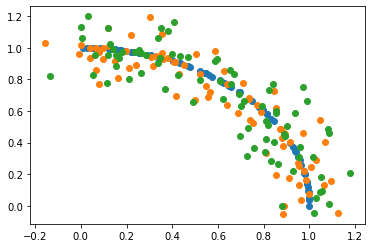

Constrastive representation


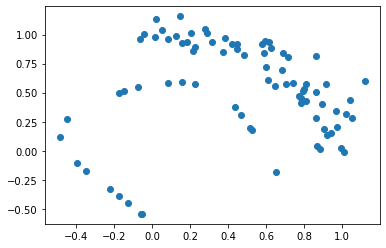

Input data distribution, blue = original data points, other colors = transformed data points


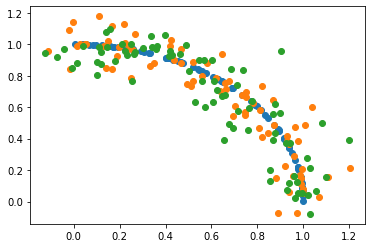

Constrastive representation


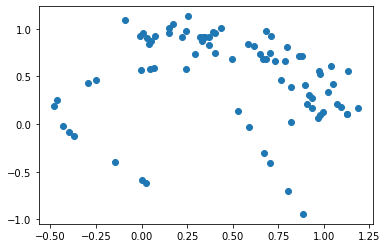

Input data distribution, blue = original data points, other colors = transformed data points


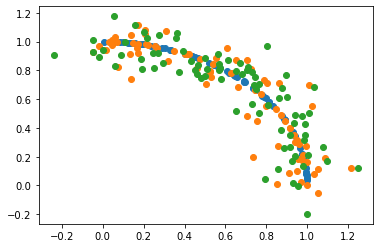

Constrastive representation


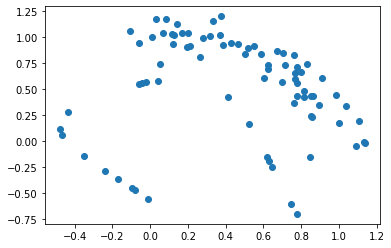

Input data distribution, blue = original data points, other colors = transformed data points


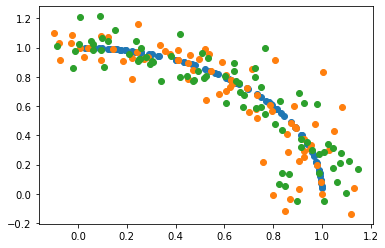

Constrastive representation


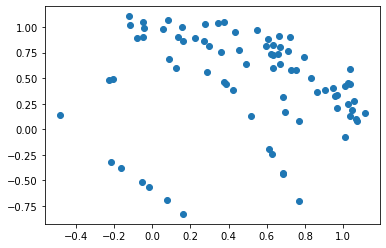

Input data distribution, blue = original data points, other colors = transformed data points


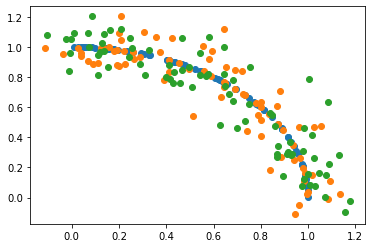

Constrastive representation


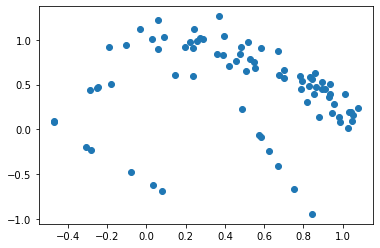

Input data distribution, blue = original data points, other colors = transformed data points


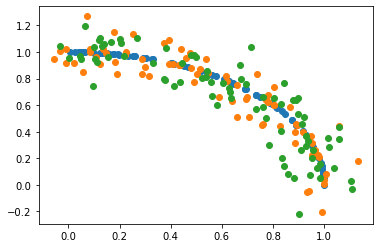

Constrastive representation


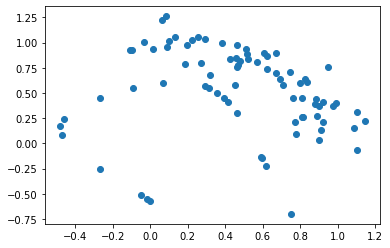

In [31]:
train_simclr(
    train_loader,
    model,
    n_epochs=n_epochs,
    plot_every=n_epochs // 5,
    print_every=0,
    lr=1e-3,
    decay=1e-5,
)